# Lithium Oven Optic 6

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.special import erf
from beam.beams import laserpulse
from beam.beams import laserbeam
from beam.elements import plasma
from beam.elements import optic
from beam import interactions
from ionization import ionization
from lens import profile
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
from lens import design
plt.style.use('notes')
%load_ext autoreload
%autoreload 2

path = '/mnt/md0/Data/rariniello/Lithium_Oven/Lithium_Oven_Optic_6/'
lam = 0.796
# All length units are in um

Test optic 6 is the first prototype we actually plan on making so the optics have to be defined to fit in FACET II's experimantal area but also work with our laser for testing. This notebook contains the detailed designs for the optics as well as simulations of the beam dump.

In [2]:
r = np.load(path+'r.npy')
E = np.load(path+'e.npy')
plasma = np.load(path+'plasma.npy')
I_ramped = np.load(path+'intensity.npy')
z = np.load(path+'z.npy')
sim_start, sim_length = np.load(path+'sim_size.npy')

Nx = 2**10
X = 10e3
tau = 30
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : True,
    'threads' : 4,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Beam',
}
pulse = laserpulse.Pulse(pulseParams)

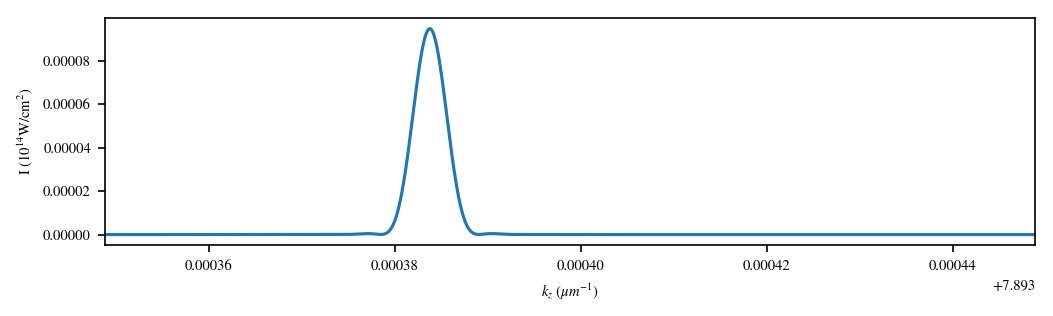

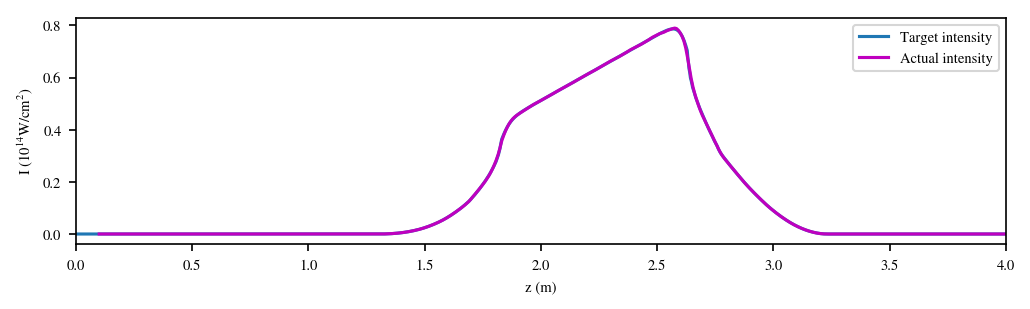

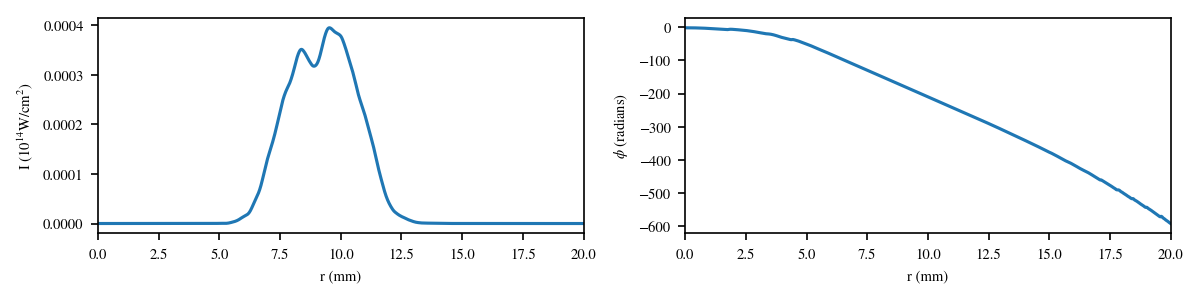

In [3]:
# Optic design upstream
z0 = 1.83075e6-sim_start
dz = z[1]-z[0]
Np = int(z0/dz)
width = 75
xlim = [0, 4]
z_optic = np.linspace(0, z[-1]+z0, len(z)+Np)
I_optic = np.append(np.zeros(Np), I_ramped)
r, E = design.calculate_tran_field(z_optic, I_optic, 20e3, width, lam, path, 10e-5, xlim, [0, 20])

Maximum phase change in one pixel 0.52 rad


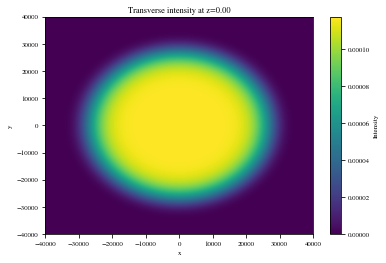

Energy through the optic 4.43mJ
Total energy 7.60mJ


In [4]:
# Design the tandem lenses to create the beam from the output of the laser
# First, we have to define what the incoming laser beam looks like
# Unifrom profile, place lens in the center of the flattop
E0 = 2.3
R_max = 15e3
r0 = np.linspace(0, R_max, len(r))
Ei = E0*np.ones(len(r))

# Call the first lens A and the second lens B first make sure the power is equal
Ii = ionization.intensity_from_field(Ei)
Io = ionization.intensity_from_field(E)
Pi = 2*np.pi*simps(r0*Ii*1e-4, r0*1e-4)*100
Po = 2*np.pi*simps(r*Io*1e-4, r*1e-4)*100
Ei *= np.sqrt(Po/Pi)
Ii = ionization.intensity_from_field(Ei)

# The first lens shapes the intensity on the second one
L = 0.8e6 # distance between the tandem optics
rA, phiA = ray.lens_design(Ii, r0, Io, r, L)
phiA *= 2*np.pi/lam

# Create the first lens
Nx = 2**13
X = 80e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensA',
              'lam' : lam,
              'load' : False}

lensA = optic.Phase(lensParams)
phi = lensA.reconstruct_from_cyl(rA, phiA, lensA.x, lensA.y)
lensA.initialize_phase(phi)

# The phase difference between neighboring cells must be less than pi
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

# Create the initial beam to pass through the lens
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam0_A_to_B',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

# Super Gaussian for simulation
n = 8
w0 = 30e3
ri = np.linspace(0, 100e3, 5000)
Ei = E0 * np.exp(-(ri/w0)**n)*np.sqrt(Po/Pi)
beam0 = laserbeam.Laser(beamParams)
np.save(path+'initial_E.npy', Ei)
np.save(path+'initial_r.npy', ri)
e = beam0.reconstruct_from_cyl(ri, Ei, beam0.x, beam0.y)
beam0.initialize_field(e)
beam0.plot_current_intensity()
print('Energy through the optic %0.2fmJ' % (beam0.total_cyl_power(r, Ii)*30e-15*1e15))
print('Total energy %0.2fmJ' % (beam0.total_cyl_power(ri, ionization.intensity_from_field(Ei))*30e-15*1e15))

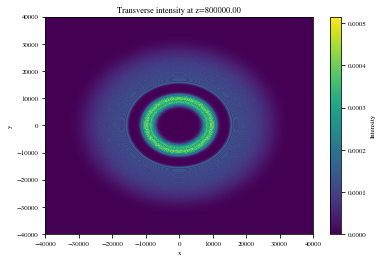

In [5]:
# Propagate the initial beam through the lens and to the second lens
# The actual phase at the second lens is needed to determine the phase delay of the lens
interactions.beam_phase(beam0, lensA)
beam0.propagate(L, 1.0)
beam0.plot_current_intensity()

In [6]:
# The second lens (B) removes the phase from the first lens and adds an axicon like phase
r0 = -beam0.x[:int(beam0.Nx/2+1)]
e0 = beam0.e[:int(beam0.Nx/2+1), int(beam0.Ny/2+1)]
phi0 = np.unwrap(np.angle(e0))
phi0 = phi0 - phi0[-1]
phiB = np.unwrap(np.angle(E)) - beam0.reconstruct_from_cyl(r0, phi0, r, np.zeros(1))[:, 0]

# Create the second lens, the domain is smaller for this one
Nx = 2**12
X = 40e3
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'LensB',
              'lam' : lam,
              'load' : False}

lensB = optic.Phase(lensParams)
phi = lensB.reconstruct_from_cyl(r, phiB, lensB.x, lensB.y)
lensB.initialize_phase(phi)
dphi = np.sort(abs(phi[1:, int(Nx/2+1)]-phi[:-1, int(Nx/2+1)]))[-3]
print('Maximum phase change in one pixel %0.2f rad' % dphi)

Maximum phase change in one pixel 2.98 rad


In [7]:
# Create a new beam after the phase shaping optics
beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Beam1_PostOptic',
              'threads' : 4,
              'cyl' : True,
              'load' : False}

beam1 = laserbeam.Laser(beamParams)
e = beam1.reconstruct_from_cyl(r0, e0, beam1.x, beam1.y)
beam1.initialize_field(e)
interactions.beam_phase(beam1, lensB)

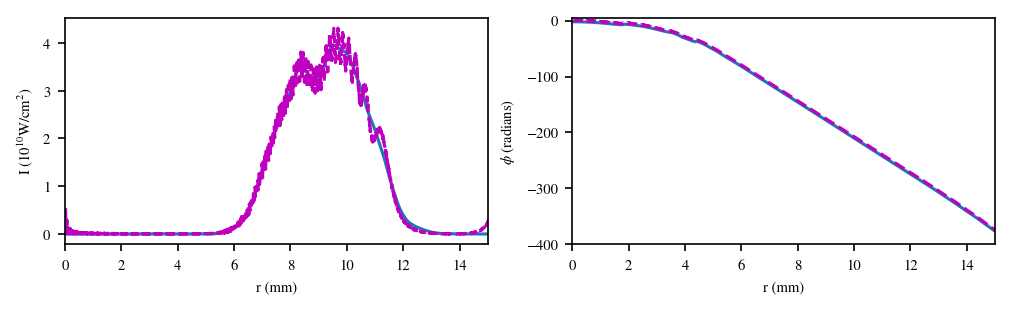

In [8]:
# Radial dependence of the phase and and intensity after the beam shaping optics
r1 = -beam1.x[:int(beam1.Nx/2+1)]
e1 = beam1.e[:int(beam1.Nx/2+1), int(beam1.Ny/2+1)]

rlim = [0, 15]
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(r/1e3, ionization.intensity_from_field(E)/1e-4)
plt.plot(r1/1e3, ionization.intensity_from_field(e1)/1e-4, 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'I ($\mathrm{10^{10}W/cm^2}$)')
plt.xlim(rlim)
plt.subplot(122)
plt.plot(r/1e3, np.unwrap(np.angle(E)))
plt.plot(r1/1e3, np.unwrap(np.angle(e1))-np.unwrap(np.angle(e1))[-1], 'm--')
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(rlim)
plt.ylim(-400, 5)
plt.show()

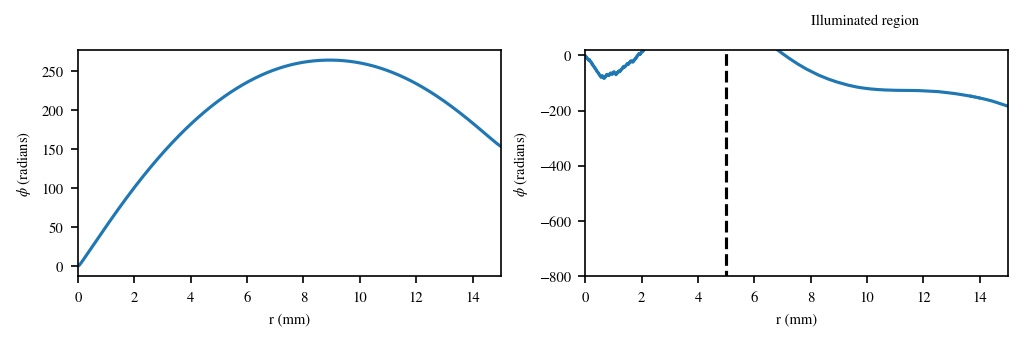

In [12]:
plt.figure(figsize=(8, 2), dpi=150)
plt.subplot(121)
plt.plot(rA/1e3, phiA)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, np.amax(rA)/1e3)
plt.subplot(122)
plt.plot(r/1e3, phiB)
plt.plot([5, 5], [-1000, 500], 'k--')
plt.text(8, 110, 'Illuminated region')
plt.arrow(5, 160, 10, 0, head_width=10, head_length=0.5, linewidth=0.5, fc='k', length_includes_head=True)
plt.arrow(15, 160, -10, 0, head_width=10, head_length=0.5, linewidth=0.5, fc='k', length_includes_head=True)
plt.xlabel(r'r (mm)')
plt.ylabel(r'$\phi$ (radians)')
plt.xlim(0, 15)
plt.ylim(-800, 20)
plt.show()

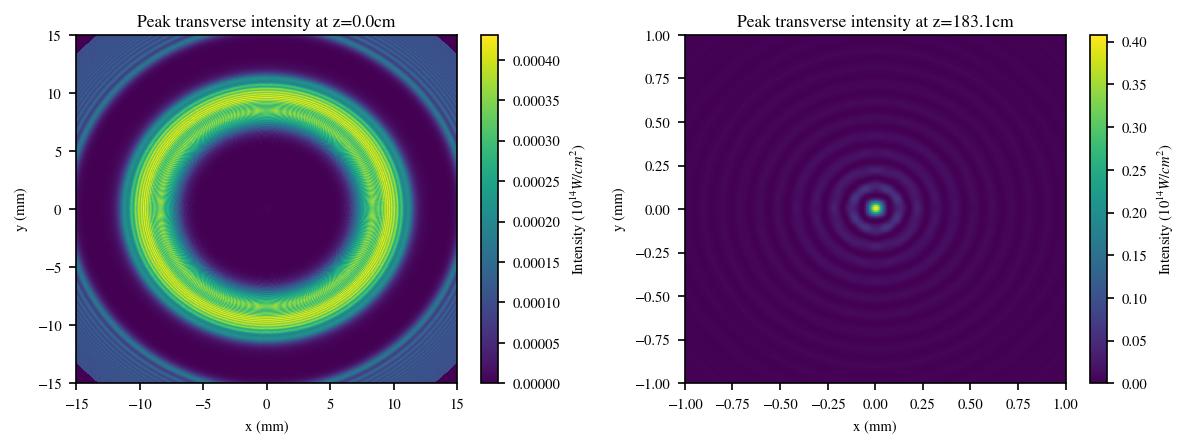

In [10]:
X = 30e3
Nx = 2**13
tau = 30
start = z0+0.85e6
beam_start, pulseParams = design.propagate_to_start(r1, e1, start, X, Nx, path, lam, tau, 20, [-1, 1])

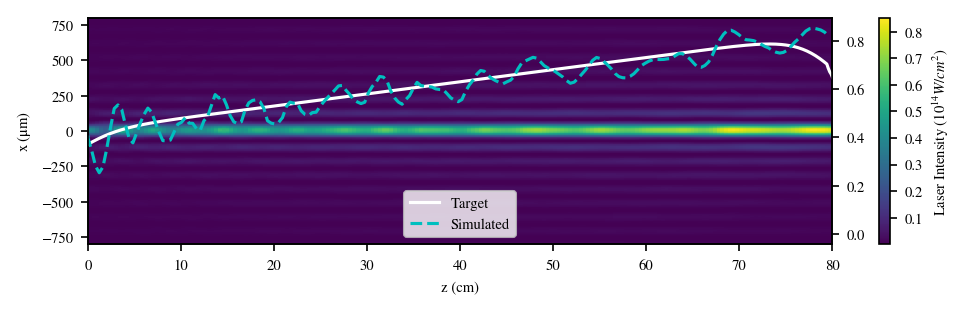

In [13]:
Nx = 2**11
Nz = 200
X = 10e3
Z = 80e4
design.domain_test(X, Nx, Z, Nz, beam_start, pulseParams, z_optic, I_optic, start, [-800, 800])

In [3]:
# Beam intensity downstream
Nx = 2**10
X = 20e3
pulseParams['name'] = 'Post_Plasma'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
pulseParams['load'] = False
pulse1 = laserpulse.Pulse(pulseParams)
e0 = np.array(pulse.e)
e = pulse1.e
for i in range(pulse.Nt):
    e[i, :, :] = pulse1.reconstruct_from_cyl(pulse.x, e0[i, :, int(pulse.Ny/2)], pulse1.x, pulse1.y)
pulse1.initialize_field(e)

In [4]:
# Propagate to the holed mirror
Nz = 200
Z = 0.85e6
z = np.linspace(0, Z, Nz)
pulse1.propagate(z, 1.0)

In [5]:
I1 = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    I1[i, :] = np.amax(pulse1.intensity_from_field(pulse1.load_field(i)[0]), axis=0)
I1 = pulse1.prep_data(I1)

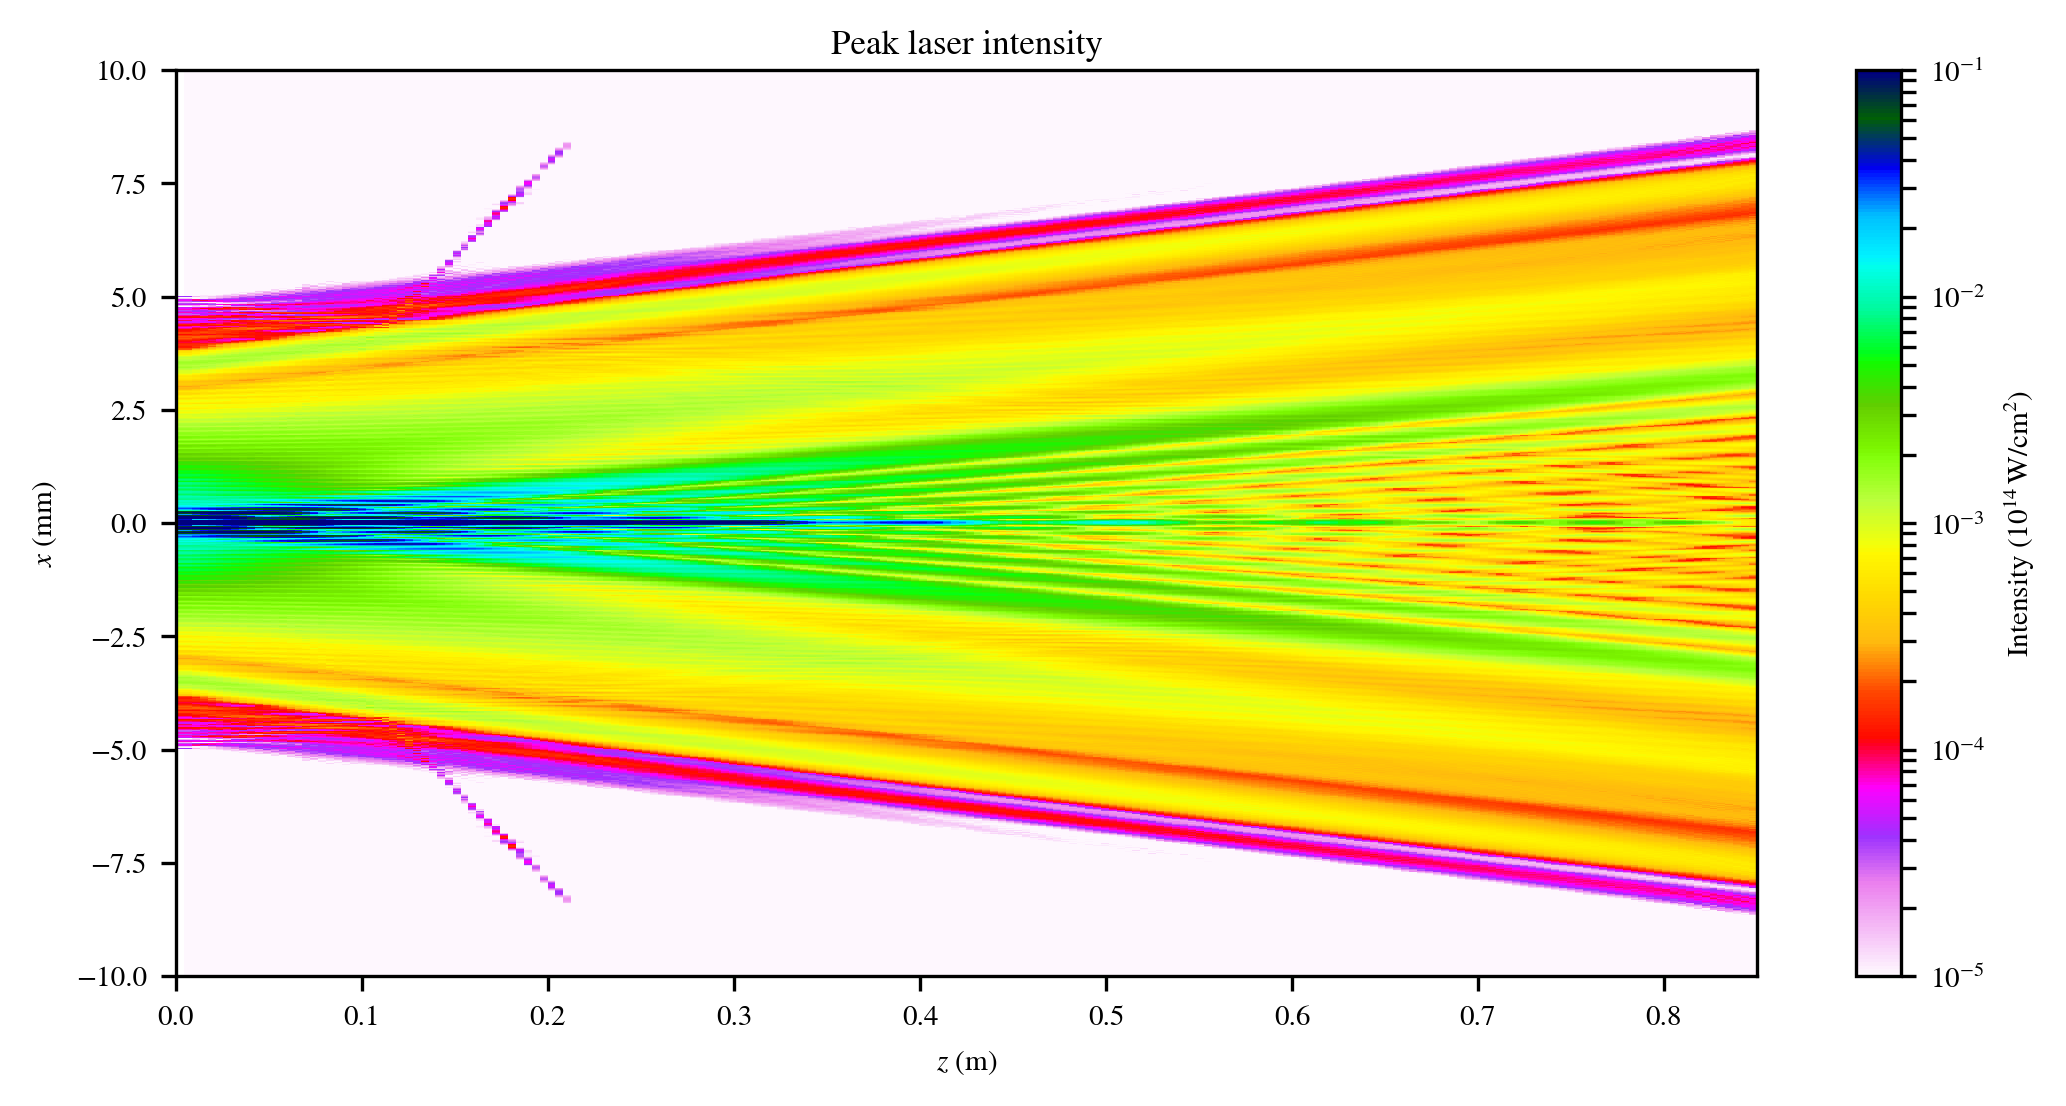

In [6]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I1, aspect='auto', extent=[0, Z/1e6, -X/2e3, X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()

In [7]:
# Reflect off of the mirror and propagate to the dump
# Create a new beam with the same intensity
Nx = 2**10
X = 40e3
pulseParams['name'] = 'Dumped_Beam'
pulseParams['Nx'] = Nx
pulseParams['Ny'] = Nx
pulseParams['X'] = X
pulseParams['Y'] = X
pulse_dump = laserpulse.Pulse(pulseParams)
e0 = np.array(pulse1.e)
e = pulse_dump.e
for i in range(pulse1.Nt):
    e[i, :, :] = pulse_dump.reconstruct_from_cyl(pulse1.x, e0[i, :, int(pulse1.Ny/2)], pulse_dump.x, pulse_dump.y)
pulse_dump.initialize_field(e)

In [8]:
# Reflect off of the mirror and out towards the dump
mirrorParams = {
    'r_in' : 1e3,
    'r_out' : 75e3,
    'Nx' : pulse_dump.Nx,
    'Ny' : pulse_dump.Nx,
    'X' : pulse_dump.X,
    'Y' : pulse_dump.X,
    'path' : path, 
    'name' : 'Dump_Mirror',
    'lam' : lam,
    'load' : False
}
mirror = optic.Annulus(mirrorParams)

In [9]:
interactions.beam_intensity(pulse_dump, mirror)

In [10]:
# Propagate 2m past the holed mirror
Nz = 200
Z = 2e6
z = np.linspace(0, Z, Nz)
pulse_dump.propagate(z, 1.0)

In [11]:
Idump = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    Idump[i, :] = np.amax(pulse_dump.intensity_from_field(pulse_dump.load_field(i+1)[0]), axis=0)
Idump = pulse_dump.prep_data(Idump)

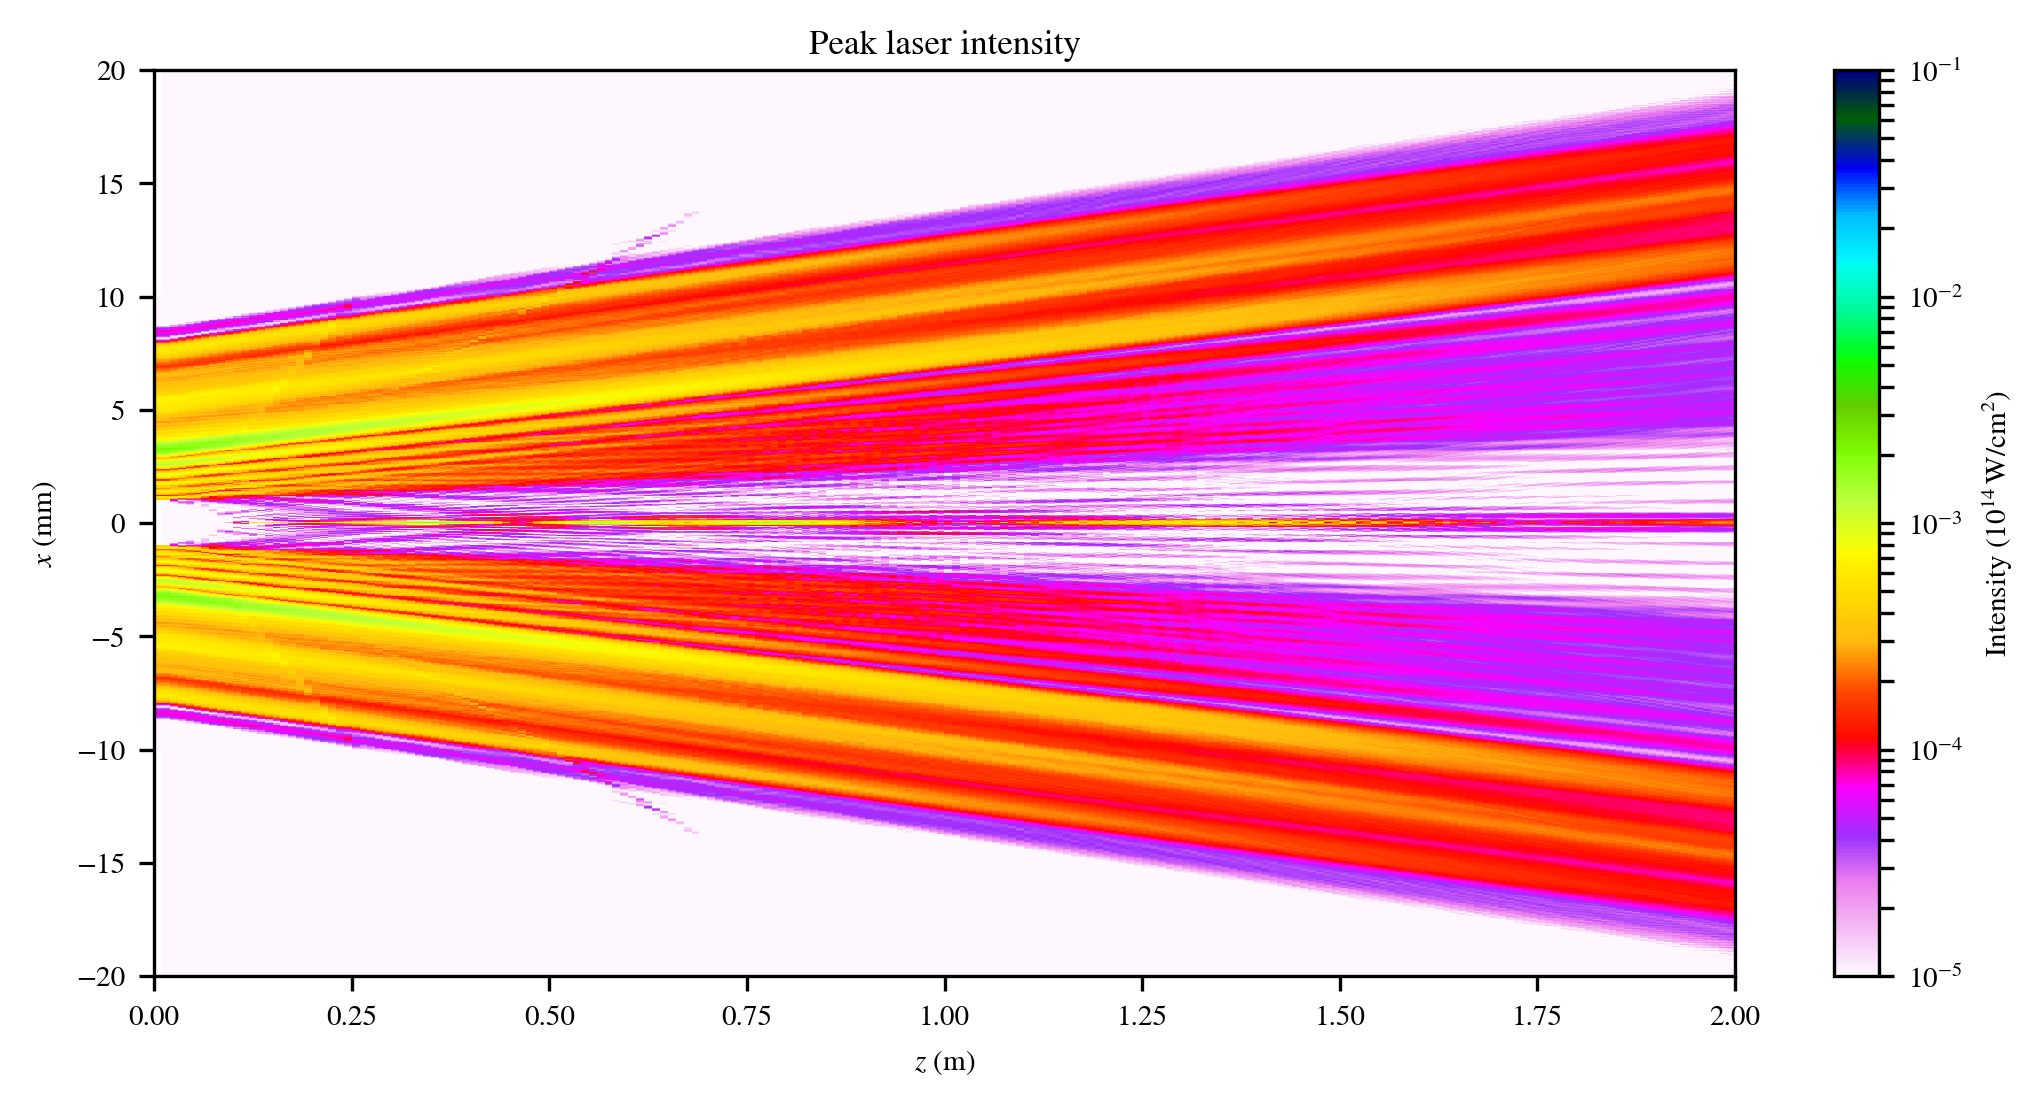

In [12]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(Idump, aspect='auto', extent=[0, Z/1e6, -pulse_dump.X/2e3, pulse_dump.X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()

In [13]:
# Continue to propagate through the accelerator
holeParams = {
    'r' : 1e3,
    'Nx' : pulse1.Nx,
    'Ny' : pulse1.Nx,
    'X' : pulse1.X,
    'Y' : pulse1.X,
    'path' : path, 
    'name' : 'Dump_Mirror_Hole',
    'lam' : lam,
    'load' : False
}
hole = optic.Aperture(holeParams)

In [14]:
interactions.beam_intensity(pulse1, hole)

In [15]:
# Propagate 2m past the holed mirror
Nz = 200
Z = 2e6
z = np.linspace(0, Z, Nz)
pulse1.propagate(z, 1.0)

In [16]:
I2 = np.zeros((Nz, Nx), dtype='double')
for i in range(Nz):
    I2[i, :] = np.amax(pulse1.intensity_from_field(pulse1.load_field(i+Nz+1)[0]), axis=0)
I2 = pulse1.prep_data(I2)

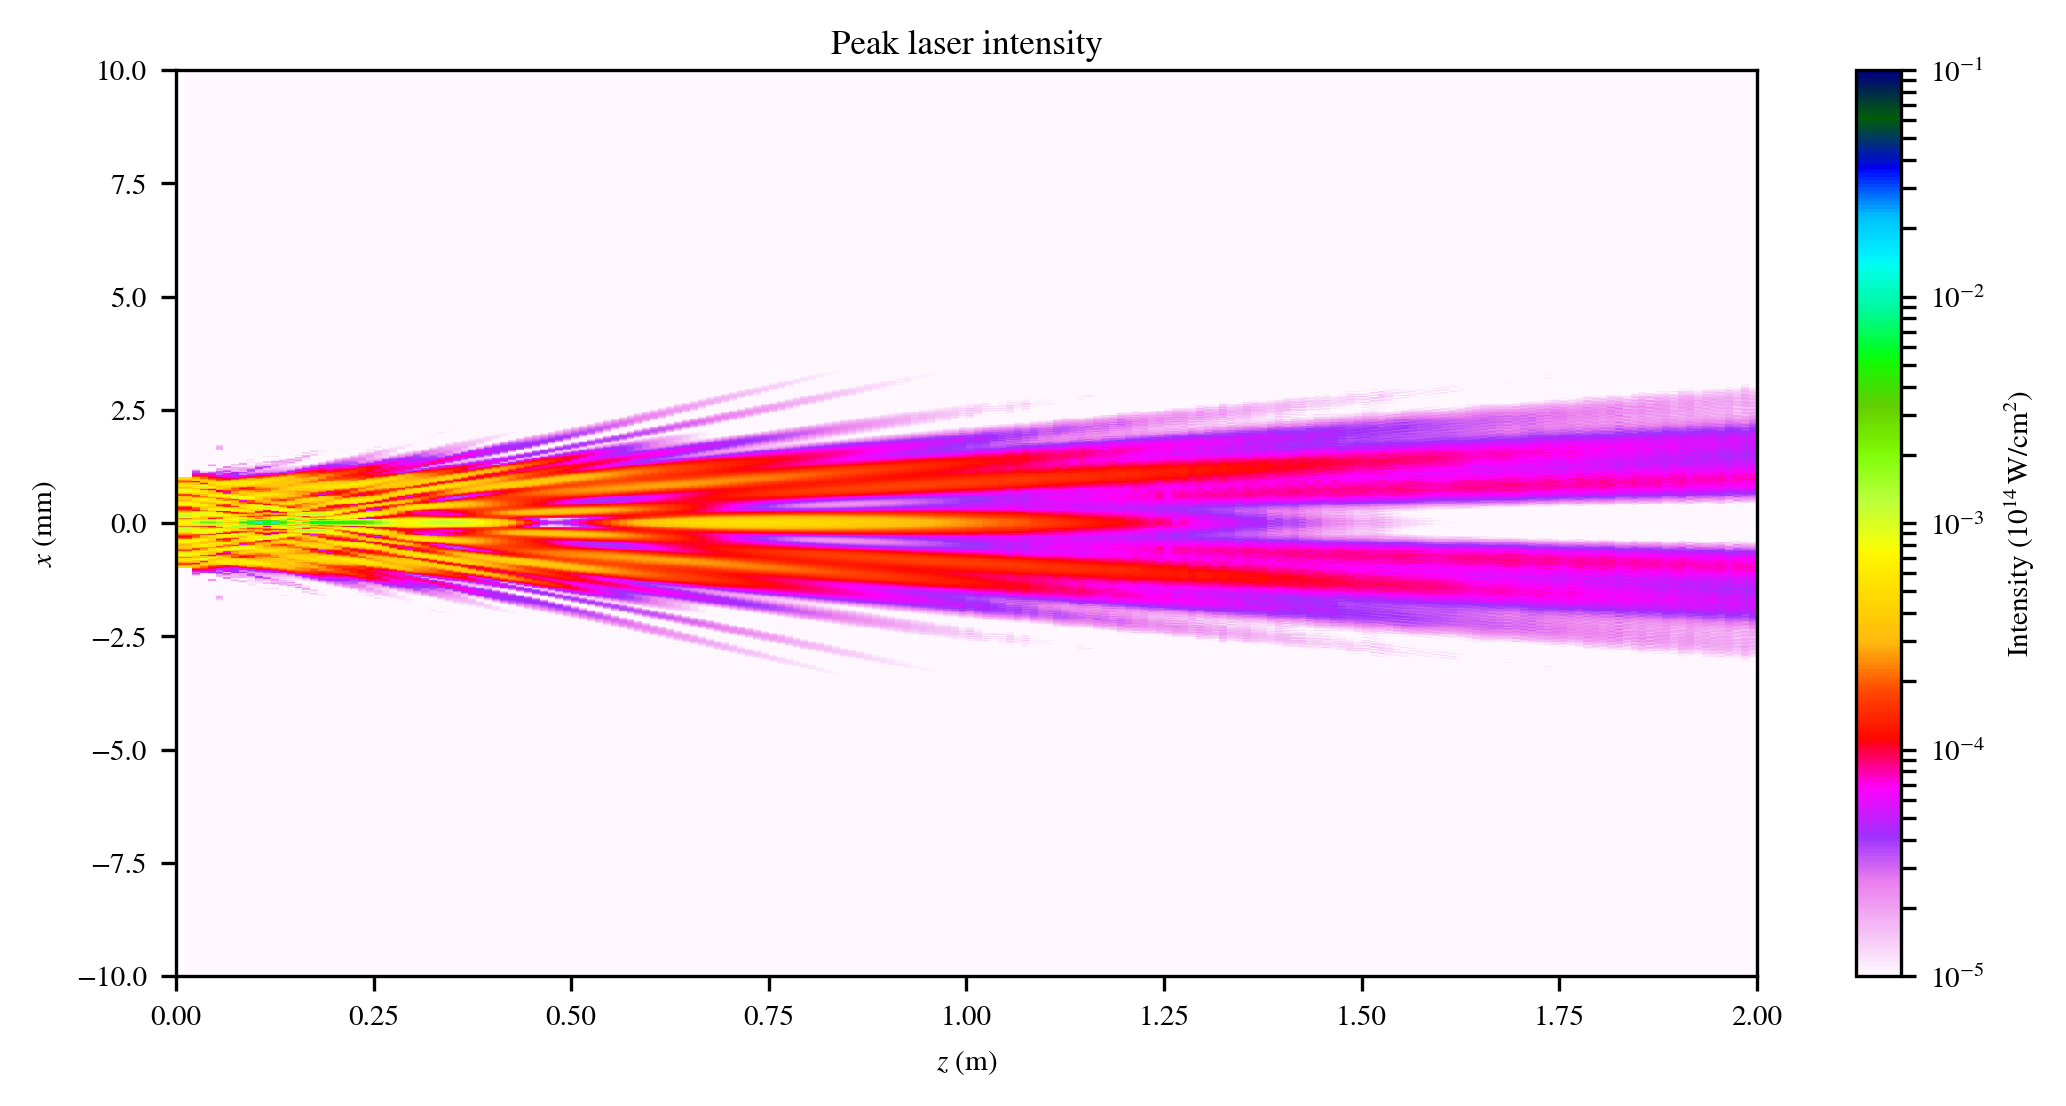

In [17]:
import matplotlib.colors as colors
plt.figure(figsize=(8.5, 4), dpi=300)
norm = colors.LogNorm(vmin=1e-5, vmax=0.1)
im = plt.imshow(I2, aspect='auto', extent=[0, Z/1e6, -pulse1.X/2e3, pulse1.X/2e3], norm=norm)
cb = plt.colorbar()
cb.set_label(r'Intensity ($10^{14}\,\mathrm{W/cm^2}$)')
plt.set_cmap('gist_ncar_r')
plt.xlabel(r'$z$ (m)')
plt.ylabel(r'$x$ (mm)')
plt.title('Peak laser intensity')
plt.show()